#### This program estimates alpha according to author frequency

We bin the articles for each month into two bins: 
    1. Written by authors with fewer than three publications in that month 
    2. Written by authors with two or more publications in that month 

In [3]:
from base import * 
import pandas as pd 
import os 
import pickle 
from pathlib import Path 
from src.estimation import estimate_text_distribution
from src.MLE import MLE
import warnings
import numpy as np 
import matplotlib.pyplot as plt 
warnings.filterwarnings("ignore")

In [4]:
subject = "education"
base_loc = f"inference_data/{subject}"
years = [2024, 2023, 2022, 2021]

In [9]:
def categorize_by_authors(collection):
    """
    maps authors to their corresponding articles  
    Args:
        collection: (base.ArticleCollection)
    Returns:
        (dict) (str) author name -> (List[int]) List of article ids
    """
    
    author_dict = {}
    count = 0 
    for ar_id in collection.all_articles:
        count += 1
        ar = collection.all_articles[ar_id]
        if ar.authors is not None and len(ar.authors) > 0:
            for author in ar.authors:
                if author not in author_dict:
                    author_dict[author] = []
                author_dict[author].append(ar_id)

    return author_dict

def bin_by_freq(data_dict, cutoff=2):
    """
    bins the data into two groups according to the cutoff
    Args:
        cutoff: (int) 
        data_dict: (dict) (object) -> List[object]
    """
    
    cutoff_left = []
    cutoff_right = []
    for key in data_dict:
        if len(data_dict[key]) <= cutoff:
            cutoff_left += data_dict[key]
        else:
            cutoff_right += data_dict[key]
            
    return set(cutoff_left), set(cutoff_right)


def add_to_sub_collection(sub_collection, main_collection, ids):
    """
    add selected articles from the main collection to sub-collection
    Args:
        sub_collection: (ArticleCollection)
        main_collection: (ArticleCollection) 
        ids: (List[object]) list of ids of articles of interest 
    """
    
    for id_ in ids:
        sub_collection.add_article(main_collection.get_article(id_), id_)       

In [11]:
thresh = 2 # equals the value in Liang et al.
dest = Path("inference_data/parquet_files/author/{}".format(subject))
dest.mkdir(parents=True, exist_ok=True)

for year in [2024, 2023, 2022, 2021]:
    dest_year = dest / str(year)
    dest_year.mkdir(parents=True, exist_ok=True)
    for file in os.listdir(f"{base_loc}/{year}"):
        if "whole" not in file:
            full_path = f"{base_loc}/{year}/{file}"
            name = file.strip(".pkl")
            with open(full_path, "rb") as f:
                data = pickle.load(f)
                month = int(file.split(".")[0].split("_")[-1])
                by_author = categorize_by_authors(data)
                #print(len(by_author))
                if len(by_author) > 0:
                    group1, group2 = bin_by_freq(by_author)
                    #print(len(group1), len(group2), data.get_size())
                    print("{}, total: {}, less than {}: {}, more than {}:{}".format(
                        name, data.get_size(), thresh, len(group1), thresh, len(group2)))
                    collection1 = ArticleCollection(subject, year, month)
                    collection2 = ArticleCollection(subject, year, month)
                    add_to_sub_collection(collection1, data, group1)
                    add_to_sub_collection(collection2, data, group2)
                    collection1.export_parquet(dest_year, f"{name}_less")
                    collection2.export_parquet(dest_year, f"{name}_more")

100
The study investigated utilization of e-learning facilities for effective instructional delivery of educational management courses in a changing world. Two research questions were raised to guide the study, and two null hypotheses were also formulated and tested at a 0.05 level of significance. A descriptive survey research design was adopted for the study. The population of the study consists of 136 which comprised 56 lecturers from RSU and 80 lecturers from IAUOE. The validation of the instrument was carried out by three experts. The reliability of the instrument was established using the test-retest method. The computation produced a reliability coefficient of 0.80. Data for this study were gathered via the use of a self-structured questionnaire named; utilization of e-learning facilities for effective instructional delivery of educational management courses in a changing world. Questionnaire (UELFFID). The research questions were analyzed using mean and standard deviation, whil

In [15]:
parquet_base_loc = "inference_data/parquet_files/author/{}".format(subject)
name = "ojs_ed"
all_results_less = {}
all_results_more = {}
model= MLE(f"distribution/{name}.parquet")
for year in [2024]:#, 2023, 2022, 2021]:
    if year not in all_results_less:
        all_results_less[year] = {}
    if year not in all_results_more:
        all_results_more[year] = {}
    parquet_year_path = "{}/{}".format(parquet_base_loc, year) 
    for f in sorted(os.listdir(parquet_year_path)):
        if ".parquet" in f and "whole" not in f:
            print("File: {}".format(f))
            month = int(f.strip(".parquet").split("_")[-2])
            full_path = "{}/{}".format(parquet_year_path, f)
            estimated,ci = model.inference(full_path,
                                     ground_truth=None, save=False)
            if estimated is not None and ci is not None :
                print(f"{estimated:10.3f},{ci:10.3f}")
                if "less" in f:
                    all_results_less[year][month] = (estimated, ci)
                elif "more" in f:
                    all_results_more[year][month] = (estimated, ci)

File: education_2024_12_less.parquet
     0.410,     0.324
File: education_2024_12_more.parquet
ERROR
File: education_2024_1_less.parquet
     0.254,     0.007
File: education_2024_1_more.parquet
     0.187,     0.019
File: education_2024_2_less.parquet
     0.285,     0.008
File: education_2024_2_more.parquet
     0.371,     0.027
File: education_2024_3_less.parquet
     0.281,     0.008
File: education_2024_3_more.parquet
     0.272,     0.024
File: education_2024_4_less.parquet
     0.297,     0.012
File: education_2024_4_more.parquet
     0.387,     0.055
File: education_2024_5_less.parquet
     0.351,     0.166
File: education_2024_5_more.parquet
ERROR
File: education_2024_6_less.parquet
     0.209,     0.060
File: education_2024_6_more.parquet
ERROR
File: education_2024_8_less.parquet
     0.506,     0.181
File: education_2024_8_more.parquet
ERROR
File: education_2024_9_less.parquet
     0.000,     0.000
File: education_2024_9_more.parquet
ERROR
File: education_2023_10_less.parqu

In [19]:
'''
output_folder = Path("output")
output_folder.mkdir(parents=True, exist_ok=True) 
with open(output_folder / "author_trend_results_less.pkl", "wb") as f:
    pickle.dump(all_results_less, f) 
with open(output_folder / "author_trend_results_more.pkl", "wb") as f:
    pickle.dump(all_results_more, f) 
'''

m: [0.035 0.032 0.024 0.064 0.08  0.053 0.022 0.024 0.039 0.047 0.022 0.038
 0.013 0.069 0.051 0.053 0.046 0.033 0.034 0.023 0.022 0.074 0.053 0.029
 0.041 0.046 0.083 0.119 0.153 0.113 0.122 0.066 0.1   0.105 0.128 0.2
 0.187 0.371 0.272 0.387]


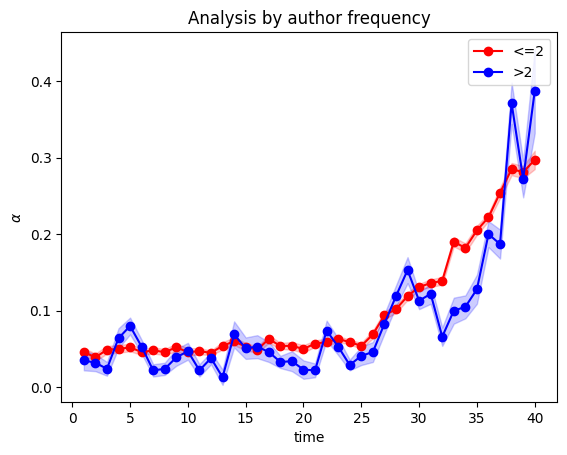

In [33]:
def convert_to_array(all_results):
    """
    extracts the alpha and confidence interval values from a dictionary 
    and converts them into array
    """
    alpha_li = []
    ci_li = []
    year_month = []
    for key1 in sorted(all_results.keys()):
        for key2 in sorted(all_results[key1]):
            if key1 != 2024:
                alpha_li.append(all_results[key1][key2][0])
                ci_li.append(all_results[key1][key2][1])
            else:
                if key2 < 5:
                    alpha_li.append(all_results[key1][key2][0])
                    ci_li.append(all_results[key1][key2][1])
            year_month.append("{}-{}".format(key1, key2))
    return np.asarray(alpha_li), np.asarray(ci_li), year_month


#output_folder = Path("output")
#output_folder.mkdir(parents=True, exist_ok=True) 
#with open(output_folder / "author_trend_results_less.pkl", "rb") as f:
#    all_results_less = pickle.load(f)
#with open(output_folder / "author_trend_results_more.pkl", "rb") as f:
#    all_results_more = pickle.load(f)
    
alpha_s, ci_s, x_lab = convert_to_array(all_results_less)
alpha_m, ci_m, x_lab = convert_to_array(all_results_more)
time = np.arange(1, len(alpha_s) +1)
#xticks = np.arange(0, len(ci_s), 3)
print("m:", alpha_m)
#tick_labs = [x_lab[i] for i in xticks]
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1) 
axes.set_xlabel("time")
axes.set_ylabel(r"$\alpha$") 
axes.set_title("Analysis by author frequency")
axes.plot(time, alpha_s, "-o", label="<={}".format(2), color="red")
axes.plot(time, alpha_m, "-o", label=">{}".format(2), color="blue")
axes.fill_between(time, (alpha_s-ci_s), (alpha_s+ci_s), 
                color='red', alpha=.2)
axes.fill_between(time, (alpha_m-ci_m), (alpha_m+ci_m), 
                color='blue', alpha=.2)
axes.legend()
#axes.set_xticks(xticks, tick_labs, rotation=90)